### Import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tensorflow import keras

### Preprocess

In [2]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (227,227))
    return image, label

### Load Data

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

### Class Labels

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Split

In [5]:
validation_images, validation_labels = train_images[:5000],train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

### To Tensorflow

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

### Plot a few examples

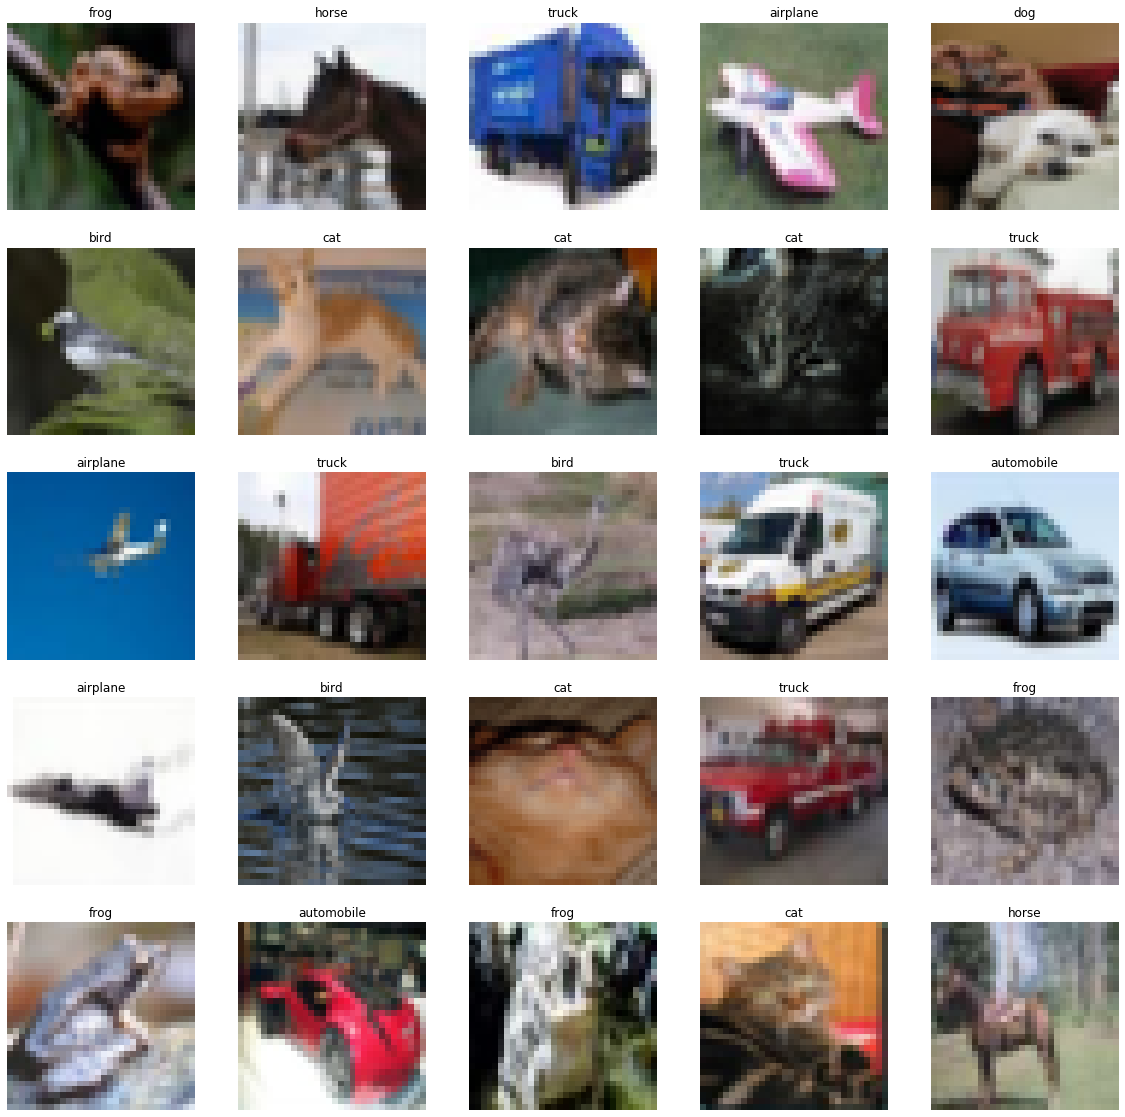

In [7]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(25)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

### Shuffle

In [8]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


### Pipeline

In [9]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Model Definition

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')])

### Logs

In [11]:
root_logdir = os.path.join(os.curdir, "logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Optimization

In [12]:
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

### Train

In [ ]:
model.fit(train_ds,epochs=10,validation_data=validation_ds,validation_freq=1,callbacks=[tensorboard_cb])

Train for 1406 steps, validate for 156 steps
Epoch 1/10
1406/1406 [==============================] - 2304s 2s/step - loss: 2.1494 - accuracy: 0.3144 - val_loss: 1.4803 - val_accuracy: 0.4816
Epoch 2/10
1406/1406 [==============================] - 2441s 2s/step - loss: 1.6264 - accuracy: 0.4236 - val_loss: 1.3506 - val_accuracy: 0.5236
Epoch 3/10
1406/1406 [==============================] - 2360s 2s/step - loss: 1.4790 - accuracy: 0.4748 - val_loss: 1.3097 - val_accuracy: 0.5381
Epoch 4/10
1406/1406 [==============================] - 2849s 2s/step - loss: 1.3699 - accuracy: 0.5155 - val_loss: 1.2085 - val_accuracy: 0.5773
Epoch 5/10
1406/1406 [==============================] - 2809s 2s/step - loss: 1.2857 - accuracy: 0.5423 - val_loss: 1.1526 - val_accuracy: 0.6028
Epoch 6/10
 771/1406 [===============>..............] - ETA: 32:34 - loss: 1.2203 - accuracy: 0.5681